In [4]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
import string

import nltk
import re
import warnings 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

In [42]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\r.lavanya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\r.lavanya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\r.lavanya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [8]:
df = pd.read_csv(r"C:\Users\r.lavanya\Desktop\Combined Data.csv")

In [9]:
df.head(5)

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [12]:
df.tail(5)

,Unnamed: 0,statement,status
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety
53042,53042,I have really bad door anxiety! It's not about...,Anxiety


In [16]:
df.describe(include='all')

,Unnamed: 0,statement,status
count,53043.000000,52681,53043
unique,NaN,51073,7
top,NaN,what do you mean?,Normal
freq,NaN,22,16351
mean,26521.000000,NaN,NaN
std,15312.339501,NaN,NaN
min,0.000000,NaN,NaN
25%,13260.500000,NaN,NaN
50%,26521.000000,NaN,NaN
75%,39781.500000,NaN,NaN


In [17]:
df.describe()

,Unnamed: 0
count,53043.000000
mean,26521.000000
std,15312.339501
min,0.000000
25%,13260.500000
50%,26521.000000
75%,39781.500000
max,53042.000000


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [19]:
df = df.drop('Unnamed: 0',axis = 1)

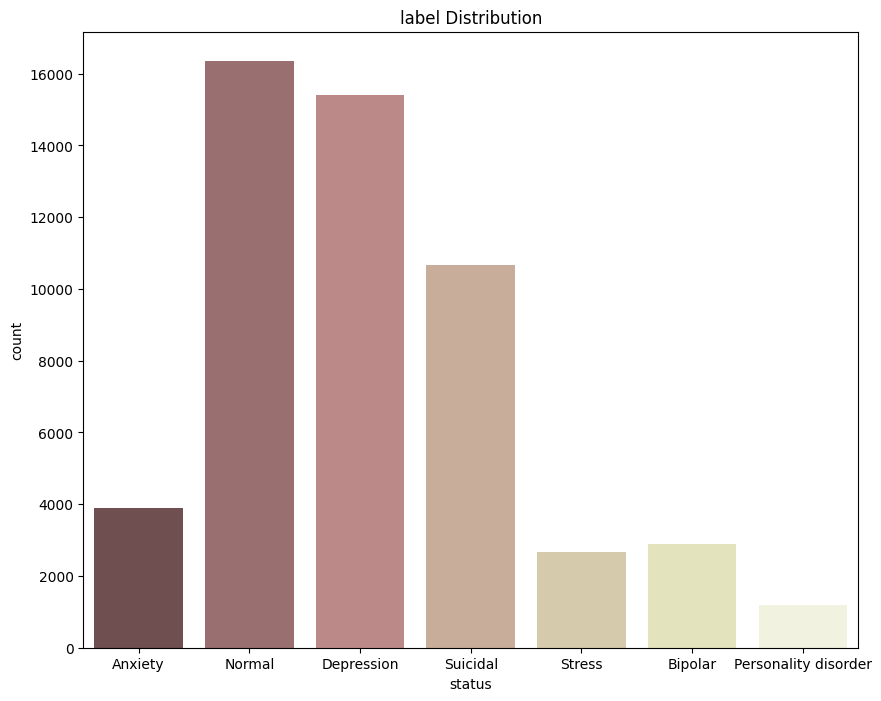

In [28]:
plt.figure(figsize=(10, 8))
sns.countplot(x='status', data=df,palette='pink')
plt.title('label Distribution')
plt.show()

In [31]:
def remove_missing_values(df):
    return df.dropna()

def remove_urls(text):
    return re.sub(r'http\S+', '', text)

def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

def remove_emojis(text):
    emoji_pattern = re.compile("[\U00010000-\U0010FFFF]", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
   
def remove_emojis(text):
    emoji_pattern = re.compile("[\U00010000-\U0010FFFF]", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_special_chars(text):
    allowed_chars = set(string.ascii_letters + "áéíóúãõàâêôç ")
    return ''.join(c for c in text if c in allowed_chars)

In [32]:
def clean_text(text):
    if not isinstance(text, str):
        return '' 
    
    text = text.lower().strip() 
    text = remove_urls(text)
    text = remove_mentions(text)
    text = remove_emojis(text)
    text = remove_special_chars(text)
    text = re.sub(r'\s+', ' ', text) 
    
    return text

df['statement'] = df['statement'].apply(clean_text)

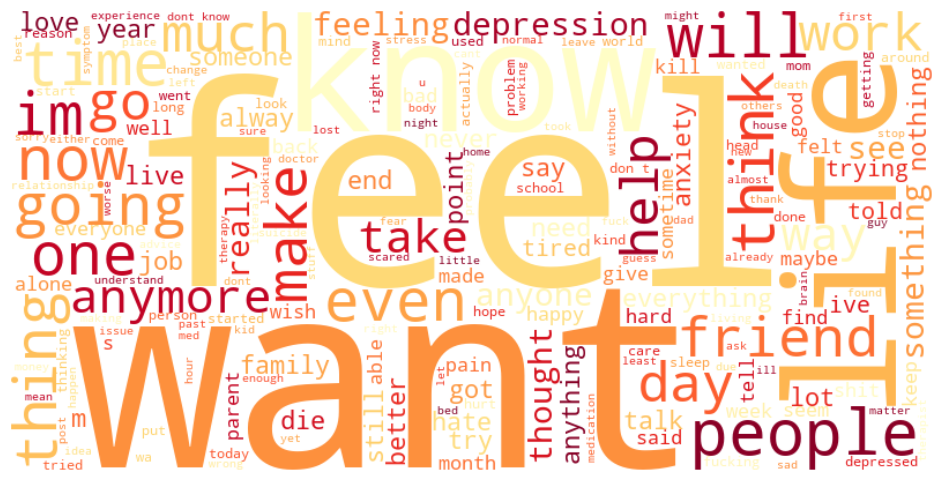

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = ' '.join(df['statement'])
wordcloud = WordCloud(width=800, height=400, 
                      background_color='white',
                      colormap='YlOrRd').generate(all_text)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [59]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word.lower() not in stop_words] 
    return tokens

df['tokenized_statement'] = df['statement'].apply(tokenize_and_remove_stopwords)


In [50]:
df['clean_text'] = df['tokenized_statement'].apply(lambda x: ' '.join(x))

In [51]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['clean_text'])

sequences = tokenizer.texts_to_sequences(df['clean_text'])

X = pad_sequences(sequences, padding='post', maxlen=100)


In [52]:
encoder = LabelEncoder()
y = df['encoded_status'] = encoder.fit_transform(df['status'])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [66]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=200),
    LSTM(128, return_sequences=False),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax') 
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 98s 99ms/step - accuracy: 0.4170 - loss: 1.5307 - val_accuracy: 0.5539 - val_loss: 1.2148
Epoch 2/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 92s 99ms/step - accuracy: 0.5657 - loss: 1.1234 - val_accuracy: 0.5913 - val_loss: 0.9827
Epoch 3/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 92s 99ms/step - accuracy: 0.6187 - loss: 0.8739 - val_accuracy: 0.6390 - val_loss: 0.8774
Epoch 4/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 92s 99ms/step - accuracy: 0.7004 - loss: 0.7176 - val_accuracy: 0.6748 - val_loss: 0.8466
Epoch 5/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 92s 99ms/step - accuracy: 0.7553 - loss: 0.6109 - val_accuracy: 0.6764 - val_loss: 0.8872
Epoch 6/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 92s 99ms/step - accuracy: 0.8206 - loss: 0.4917 - val_accuracy: 0.6986 - val_loss: 0.8981
Epoch 7/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 92s 98ms/step - accuracy: 0.8602 - loss: 0.3993 - val_accuracy: 0.6965 - val_loss: 0.9975
Epoch 8/20
929/929 ━━━━━━━━━━━━━━━━━━━━ 92s 99ms/step - accuracy: 0.8849 - loss: 0.3426 - 

In [67]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

498/498 ━━━━━━━━━━━━━━━━━━━━ 28s 56ms/step - accuracy: 0.7097 - loss: 1.7230
Test Accuracy: 0.7104


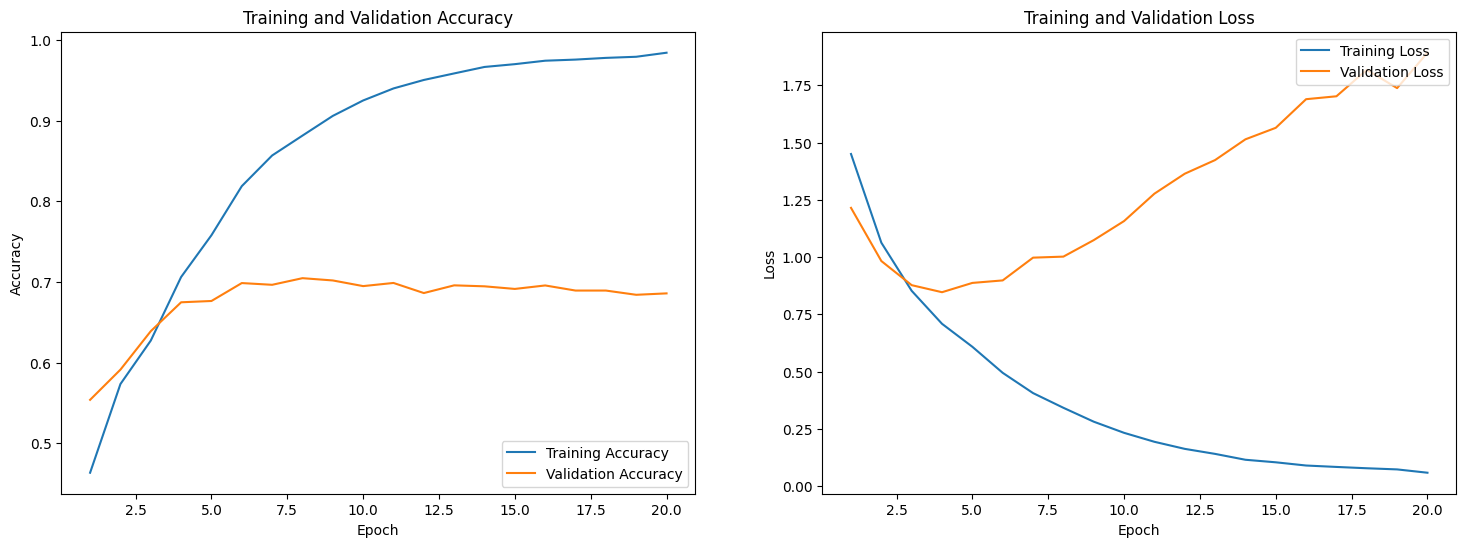

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

#Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

498/498 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step


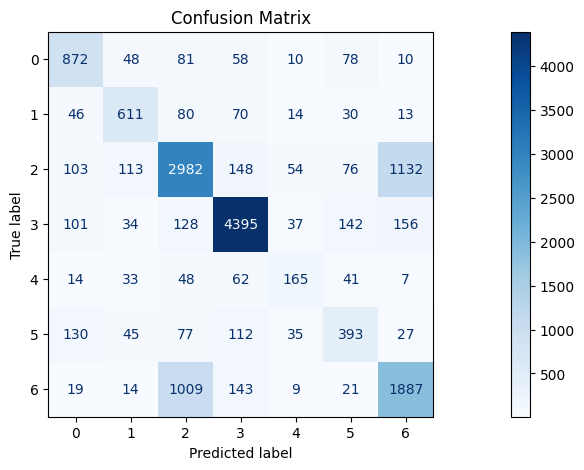

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(20, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix')
plt.show()

In [70]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def predict_sentiment(text):
    cleaned = clean_text(text)
    tokens = tokenize_and_remove_stopwords(cleaned)
    joined = ' '.join(tokens)
    sequence = tokenizer.texts_to_sequences([joined])
    padded = pad_sequences(sequence, padding='post', maxlen=100)
    prediction = model.predict(padded)
    predicted_class = np.argmax(prediction, axis=1)[0]
    label = encoder.inverse_transform([predicted_class])[0]
    confidence = prediction[0][predicted_class]
    return label, confidence

In [71]:
# Widgets
text_input = widgets.Textarea(
    value='',
    placeholder='Type something...',
    description='Input:',
    layout=widgets.Layout(width='600px', height='100px'),
    disabled=False
)

output = widgets.Output()

In [72]:
def on_button_click(b):
    with output:
        clear_output()
        user_text = text_input.value
        if user_text.strip() == "":
            print("Please enter some text.")
        else:
            label, conf = predict_sentiment(user_text)
            print(f"Predicted Sentiment: {label} (Confidence: {conf:.2f})")

button = widgets.Button(description="Predict")
button.on_click(on_button_click)


In [73]:
# Display
display(text_input)
display(button)
display(output)

Textarea(value='', description='Input:', layout=Layout(height='100px', width='600px'), placeholder='Type somet…

Button(description='Predict', style=ButtonStyle())

Output()

In [78]:
model.save("sentiment_model.keras")

In [79]:
model.save("sentiment_model.keras")

import pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(encoder, f)